<a href="https://colab.research.google.com/github/MeseretA/ResNet-for-Regressor-Seminar/blob/main/ResNet_Seminar_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNET
Since ResNET is originally created for image recognition, its residual block uses Conv3D layers and pooling layers.
In order to use ResNET for regression problems, we need to replace each block layers with Conv1D and 1 dimensional pooling. In addition to that, we need to modify the output layer activation function, which is usually `linear` for regression.
# 1 Dimensional Convolution (Conv1D) for Regression
In regression problem, we aim to predict the output of a continuous value. Typically, data for regression problem is in the shape of `[batch_size, features]`. However, Conv1D layer expects input shape in 3D as `[batch_size, time_steps, input_dimension]`. Thus, we need to reshape our data sets.

In [137]:
!pip install tensorflow_addons

In [138]:
import os
import pandas as pd
import numpy as np
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import math

import tensorflow.keras as keras
import time

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split


import tensorflow_addons as tfa

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from google.colab import drive
drive.mount('/content/drive')

# Importing the training set
dataset_train = pd.read_csv("/content/drive/MyDrive/TestDataWithPose.csv", header= None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
dataset_train.head()

,0,1,2
0,-0.000499,-0.000043,-0.011229
1,-0.000998,-0.000084,-0.022465
2,-0.001497,-0.000124,-0.034352
3,-0.001996,-0.000162,-0.046893
4,-0.002495,-0.000201,-0.058781


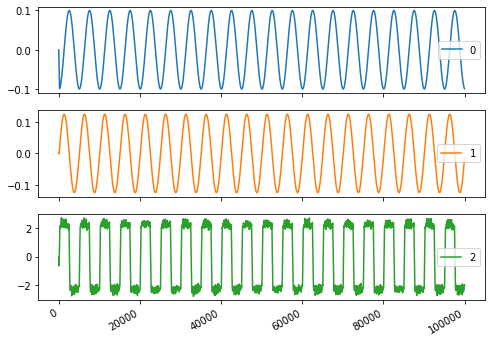

In [140]:
plot_cols = [0, 1, 2]
plot_features = dataset_train[plot_cols]
_=plot_features.plot(subplots=True)

In [141]:
column_indices = {name: i for i, name in enumerate(dataset_train.columns)}
n = len(dataset_train)
train_data = dataset_train[0:int(n*0.7)]
val_data = dataset_train[int(n*0.7):int(n*0.9)]
test_data = dataset_train[int(n*0.9):]

num_features = dataset_train.shape[1]

train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean)/train_std
val_data = (val_data - train_mean)/train_std
test_data = (test_data - train_mean)/train_std

In [142]:
# change ot numpy
train_data = train_data.to_numpy()
val_data = val_data.to_numpy()
test_data = test_data.to_numpy()

# Reshape Data sets
Conv1D layer expects input shape in 3D as 

`[batch_size, time_steps, input_dimension]`

However, current data is in the shape of

`[batch_size, features]`

**Basically, we will convert features to time steps**

To convert 2D of input data into a 3D input, we simply `reshape` as follows:

In [143]:
# Reshape to use Conv1D

# training data
sample_size_train = train_data.shape[0] # number of samples in train set
time_steps_train = train_data.shape[1]  # number of features in train set
input_dimension_train = 1               # each feature is represented by 1 number

train_data_reshaped = train_data.reshape(sample_size_train, time_steps_train, input_dimension_train)

# test data
sample_size_test = test_data.shape[0] # number of samples in train set
time_steps_test = test_data.shape[1]  # number of features in train set
input_dimension_test = 1               # each feature is represented by 1 number

test_data_reshaped = test_data.reshape(sample_size_test, time_steps_test, input_dimension_test)

#validation data
sample_size_val = val_data.shape[0] # number of samples in train set
time_steps_val = val_data.shape[1]  # number of features in train set
input_dimension_val = 1               # each feature is represented by 1 number

val_data_reshaped = val_data.reshape(sample_size_val, time_steps_val, input_dimension_val)


In [144]:
x_train = train_data_reshaped[:,:2,:]
y_train = train_data_reshaped[:,2,:]
x_test = test_data_reshaped[:,:2,:]
y_test = test_data_reshaped[:,2,:]
y_test.shape

(10000, 1)

In [145]:
input_shape = x_train.shape[1:]
input_shape

(2, 1)

In [146]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
def calculate_metrics(y_true, y_pred, duration, y_true_val=None, y_pred_val=None):
    res = pd.DataFrame(data=np.zeros((1, 4), dtype=np.float), index=[0],
                       columns=['precision', 'accuracy', 'recall', 'duration'])
    res['precision'] = precision_score(y_true, y_pred, average='macro')
    res['accuracy'] = accuracy_score(y_true, y_pred)

    if not y_true_val is None:
        # this is useful when transfer learning is used with cross validation
        res['accuracy_val'] = accuracy_score(y_true_val, y_pred_val)

    res['recall'] = recall_score(y_true, y_pred, average='macro')
    res['duration'] = duration
    return res

In [147]:
def plot_epochs_metric(hist, file_name, metric='loss'):
    plt.figure()
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_' + metric])
    plt.title('model ' + metric)
    plt.ylabel(metric, fontsize='large')
    plt.xlabel('epoch', fontsize='large')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(file_name, bbox_inches='tight')
    plt.close()

In [148]:
def save_test_duration(file_name, test_duration):
    res = pd.DataFrame(data=np.zeros((1, 1), dtype=np.float), index=[0],
                       columns=['test_duration'])
    res['test_duration'] = test_duration
    res.to_csv(file_name, index=False)

In [149]:
def save_logs(output_directory, hist, y_pred, y_true, duration, lr=False, y_true_val=None, y_pred_val=None):
    hist_df = pd.DataFrame(hist.history)
    hist_df.to_csv(output_directory + 'history.csv', index=False)

    #df_metrics = calculate_metrics(y_true, y_pred, duration, y_true_val, y_pred_val)
    #df_metrics.to_csv(output_directory + 'df_metrics.csv', index=False)

    index_best_model = hist_df['loss'].idxmin()
    row_best_model = hist_df.loc[index_best_model]

    df_best_model = pd.DataFrame(data=np.zeros((1, 6), dtype=np.float), index=[0],
                                 columns=['best_model_train_loss', 'best_model_val_loss', 'best_model_train_acc',
                                          'best_model_val_acc', 'best_model_learning_rate', 'best_model_nb_epoch'])

    df_best_model['best_model_train_loss'] = row_best_model['loss']
    df_best_model['best_model_val_loss'] = row_best_model['val_loss']
    df_best_model['best_model_train_acc'] = row_best_model['mse']
    df_best_model['best_model_val_acc'] = row_best_model['val_mse']
    if lr == True:
        df_best_model['best_model_learning_rate'] = row_best_model['lr']
    df_best_model['best_model_nb_epoch'] = index_best_model

    df_best_model.to_csv(output_directory + 'df_best_model.csv', index=False)

    # for FCN there is no hyperparameters fine tuning - everything is static in code

    # plot losses
    plot_epochs_metric(hist, output_directory + 'epochs_loss.png')


In [150]:

class Regressor_RESNET():

    def __init__(self, output_directory, input_shape, nb_classes, verbose=False, build=True, load_weights=False):
        self.output_directory = output_directory
        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose
            if load_weights == True:
                self.model.load_weights(self.output_directory
                                        .replace('resnet_augment', 'resnet')
                                        .replace('Fric_itr_augment_x_10', 'Fric_itr_10')
                                        + '/model_init.hdf5')
            else:
                self.model.save_weights(self.output_directory + 'model_init.hdf5')
        return

    def build_model(self, input_shape, nb_classes):
        n_feature_maps = 64

        input_layer = keras.layers.Input(input_shape)

        # BLOCK 1

        conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        output_block_1 = keras.layers.add([shortcut_y, conv_z])
        output_block_1 = keras.layers.Activation('relu')(output_block_1)

        # BLOCK 2

        conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        output_block_2 = keras.layers.add([shortcut_y, conv_z])
        output_block_2 = keras.layers.Activation('relu')(output_block_2)

        # BLOCK 3

        conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # no need to expand channels because they are equal
        shortcut_y = keras.layers.BatchNormalization()(output_block_2)

        output_block_3 = keras.layers.add([shortcut_y, conv_z])
        output_block_3 = keras.layers.Activation('relu')(output_block_3)

        # FINAL

        gap_layer = keras.layers.BatchNormalization()(output_block_3)

        #output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)
        output_layer = keras.layers.Dense(1, activation='linear')(gap_layer)        

        model = keras.models.Model(inputs=input_layer, outputs=output_layer)

        #model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
        #              metrics=['accuracy'])
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(),
                      metrics=['mse'])

        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
        #history = model.fit(X_train, y_train, epochs=50, batch_size=5000, verbose=2, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=2, mode='auto')], validation_split=0.1)
        early_stoping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=2, mode='auto')
        file_path = self.output_directory + 'best_model.hdf5'

        model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',
                                                           save_best_only=True)

        self.callbacks = [reduce_lr, model_checkpoint, early_stoping]

        return model

    def fit(self, x_train, y_train, x_val, y_val, y_true):
        if not tf.test.is_gpu_available:
            print('error')
            exit()
        # x_val and y_val are only used to monitor the test loss and NOT for training
        batch_size = 64
        nb_epochs = 40#800 #1500

        mini_batch_size = int(min(x_train.shape[0] / 10, batch_size))

        start_time = time.time()

        hist = self.model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=nb_epochs,
                              verbose=self.verbose, validation_data=(x_val, y_val), callbacks=self.callbacks)

        duration = time.time() - start_time

        self.model.save(self.output_directory + 'last_model.hdf5')

        y_pred = self.predict(x_val, y_true, x_train, y_train, y_val,
                              return_df_metrics=False)

        # save predictions
        np.save(self.output_directory + 'y_pred.npy', y_pred)

        # convert the predicted from binary to integer
        #y_pred = np.argmax(y_pred, axis=1)

        save_logs(self.output_directory, hist, y_pred, y_true, duration)

        keras.backend.clear_session()

        return hist

    def predict(self, x_test, y_true, x_train, y_train, y_test, return_df_metrics=False):
        start_time = time.time()
        model_path = self.output_directory + 'best_model.hdf5'
        model = keras.models.load_model(model_path)
        y_pred = model.predict(x_test)
        if return_df_metrics:
            #y_pred = np.argmax(y_pred, axis=1)
            df_metrics = calculate_metrics(y_true, y_pred, 0.0)
            return df_metrics
        else:
            test_duration = time.time() - start_time
            save_test_duration(self.output_directory + 'test_duration.csv', test_duration)
            return y_pred

# Train the model
The model is trained for 40 epochs

In [151]:
output_directory =   '/content/drive/MyDrive/Colab Notebooks/Seminar'  # Change to your directory
classifier = Regressor_RESNET(output_directory, input_shape, 1, verbose=True)
hist = classifier.fit(x_train, y_train, x_test, y_test, y_test)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 1)]       0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2, 64)        576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2, 64)        256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2, 64)        0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
1094/1094 [==============================] - 51s 46ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 3/40
1094/1094 [==============================] - 51s 46ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 4/40
1094/1094 [==============================] - 51s 46ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 5/40
1094/1094 [==============================] - 51s 46ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/40
1094/1094 [==============================] - 51s 47ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 7/40
1094/1094 [==============================] - 51s 46ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 8/40
1094/1094 [==============================] - 52s 47ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 9/40
1094/1094 [==========================

Visualize the model's training progress. 

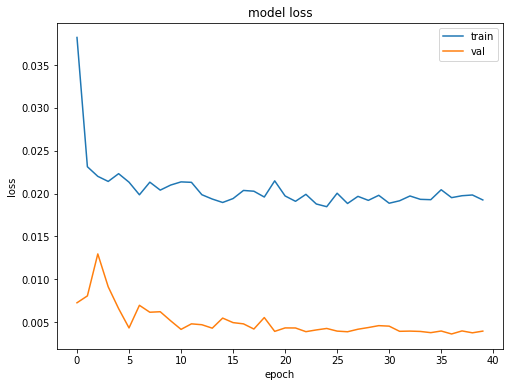

In [152]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [153]:
output_directory =   '/content/drive/MyDrive/Colab Notebooks/Seminar'  # Change to your directory
model_path = output_directory + 'best_model.hdf5'
model = keras.models.load_model(model_path)
start_time = time.time()
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
duration = time.time() - start_time
duration

1.7850852012634277

In [154]:
x_test_plt = x_test.reshape(x_test.shape[0], x_test.shape[1])

In [155]:
x_test_plt.shape

(10000, 2)

In [156]:
x_test_plt_pos = x_test_plt[:,0]*train_std.to_numpy()[0] + train_mean.to_numpy()[0]
x_test_plt_vel = x_test_plt[:,1]*train_std.to_numpy()[1] + train_mean.to_numpy()[1]
y_pred = y_pred*train_std.to_numpy()[2] + train_mean.to_numpy()[2]

In [157]:
y_pred.shape

(10000, 2)

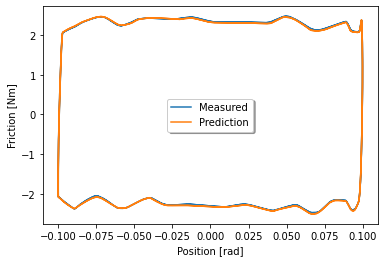

In [158]:
plt.figure(figsize=(6,4))
plt.plot(x_test_plt_pos, y_pred[:,0], label='Measured')
#plt.plot(x_test_plt_vel, y_pred[:,0], label='Measured')
plt.plot(x_test_plt_pos, y_pred[:,1], label='Prediction')
#plt.plot(x_test_plt_vel, y_pred[:,1], label='Prediction')
#plt.xlabel('Velocity [rad/s]')
plt.xlabel('Position [rad]')
plt.ylabel('Friction [Nm]')
plt.legend(shadow=True, fancybox=True)
plt.savefig('ResNetTrained.png')
#plt.savefig('Output.png')